# **Data Preprocessing and Data Analysis Workflow**

## Importing the required libraries

In [ ]:
import pandas as pd #Used for data manipulation and analysis, particularly for working with dataframes.
import numpy as np #Provides support for numerical operations and array manipulation.

from sklearn.preprocessing import StandardScaler  #Standardizes features by removing the mean and scaling to unit variance.
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score # train_test_split- Splits a dataset into training and testing sets. #cross_val_score-Evaluates a model's performance using cross-validation.
from sklearn.feature_selection import RFE, SelectKBest, f_classif - #RFE- Performs recursive feature elimination to select the most relevant features.
from sklearn.linear_model import LogisticRegression #Linear model for the binary classification task
from imblearn.combine import SMOTEENN #Technique from imblearn for handling imbalanced datasets

from scipy.stats import pearsonr, spearmanr -  # Functions from SciPy used to calculate Pearson and Spearman correlation coefficients, respectively, for measuring the linear and monotonic relationships between variables.
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report #Metrics from scikit-learn used to evaluate the performance of classification models.
from scipy.stats import norm #Provides functionality for working with probability distributions -the normal distribution.


import matplotlib.pyplot as plt #Plotting library for creating visualizations.
import seaborn as sns #Data visualization library for creating informative statistical graphics.


##Initial loading of data - The output data of the data abstraction workflow




In [ ]:
# Load the dataset
file_path = 'BlockGDF_forDataAnalysis.csv'
data = pd.read_csv(file_path)

##Data Preprocessing


###Data Cleaning

In [ ]:
#Drop columns that are not required for analysis
data = data.drop(columns=['Unnamed: 0', 'level_0', 'index', 'geometry','centroid', 'block_id','grid_area','valid_geometry','building_count_y'])
#Renaming column for ease of use
data=data.rename(columns={"building_count_x": "building_count"})

In [ ]:
# Ensure the target variables are binary categories
data['y_Slum'] = data['y_Slum'].astype(int)
data['y_Conflict'] = data['y_Conflict'].astype(int)

In [ ]:
#Outlier removal (Identification done based on IQR)
data = data[data.coverage>=0.10]
data = data[data.building_count>6]
data = data[data.building_count<4000]

In [ ]:
#Replace Missing Values with zero
data.fillna(0, inplace=True)

In [ ]:
# Define features and targets
features = data.drop(columns=['y_Slum', 'y_Conflict'])
target_slum = data['y_Slum']
target_conflict = data['y_Conflict']

### Feature Engineering

In [ ]:
# New features derived based on existing features from the dataframe
features['building_density'] = features['building_count'] / (features['Total_building_area'] + 1e-5)
features['avg_building_size'] = features['Total_building_area'] / (features['building_count'] + 1e-5)
features['complexity_density_interaction'] = features['k_complexity'] * features['building_density']
features['perimeter_density_interaction'] = features['avg_building_perimeter'] * features['building_density']
#Dropping redundant features
features = features.drop(columns=['coverage'])

In [ ]:
#Binning to transform continuouse variable into a categorical variable to simply analysis
bins = pd.IntervalIndex.from_tuples([(4, 5), (5, 6), (6, 7), (7, 8), (8, 31)])
names = ['<=5', '5-6', '6-7', '7-8', '8+']

features['avg_number_vertices_range'] = pd.cut(features['avg_number_vertices'], bins, labels=names)

In [ ]:
# One-hot encoding to convert the categories into a numerical format that the model can understand.
features = pd.get_dummies(features, columns=['avg_number_vertices_range'])

In [ ]:
#Dropping the original continuous variable
features = features.drop(columns=['avg_number_vertices'])

In [ ]:
# Standardize numerical features
numerical_features = features.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

In [ ]:
# Correlation Analysis
correlation_matrix = features.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
features.drop(columns=high_correlation_features, inplace=True)

In [ ]:
# Univariate Selection for y_Slum
selector_slum = SelectKBest(f_classif, k=20)
selector_slum.fit(features, target_slum)
selected_features_slum = features.columns[selector_slum.get_support()]

In [ ]:
# Recursive Feature Elimination (RFE) for y_Slum
rfe_slum = RFE(estimator=LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000), n_features_to_select=20, step=1)
rfe_slum.fit(features, target_slum)
selected_features_rfe_slum = features.columns[rfe_slum.get_support()]

In [ ]:
# Combining selected features for y_Slum
final_selected_features_slum = list(set(selected_features_slum) | set(selected_features_rfe_slum))

In [ ]:
# Univariate Selection for y_Conflict
selector_conflict = SelectKBest(f_classif, k=20)
selector_conflict.fit(features, target_conflict)
selected_features_conflict = features.columns[selector_conflict.get_support()]

In [ ]:
# Recursive Feature Elimination (RFE) for y_Conflict
rfe_conflict = RFE(estimator=LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000), n_features_to_select=20, step=1)
rfe_conflict.fit(features, target_conflict)
selected_features_rfe_conflict = features.columns[rfe_conflict.get_support()]

In [ ]:
# Combining selected features for y_Conflict
final_selected_features_conflict = list(set(selected_features_conflict) | set(selected_features_rfe_conflict))

In [ ]:
#Finally combining all selected features to form the final feature set for model training
final_selected_features = list(set(final_selected_features_slum) | set(final_selected_features_conflict))


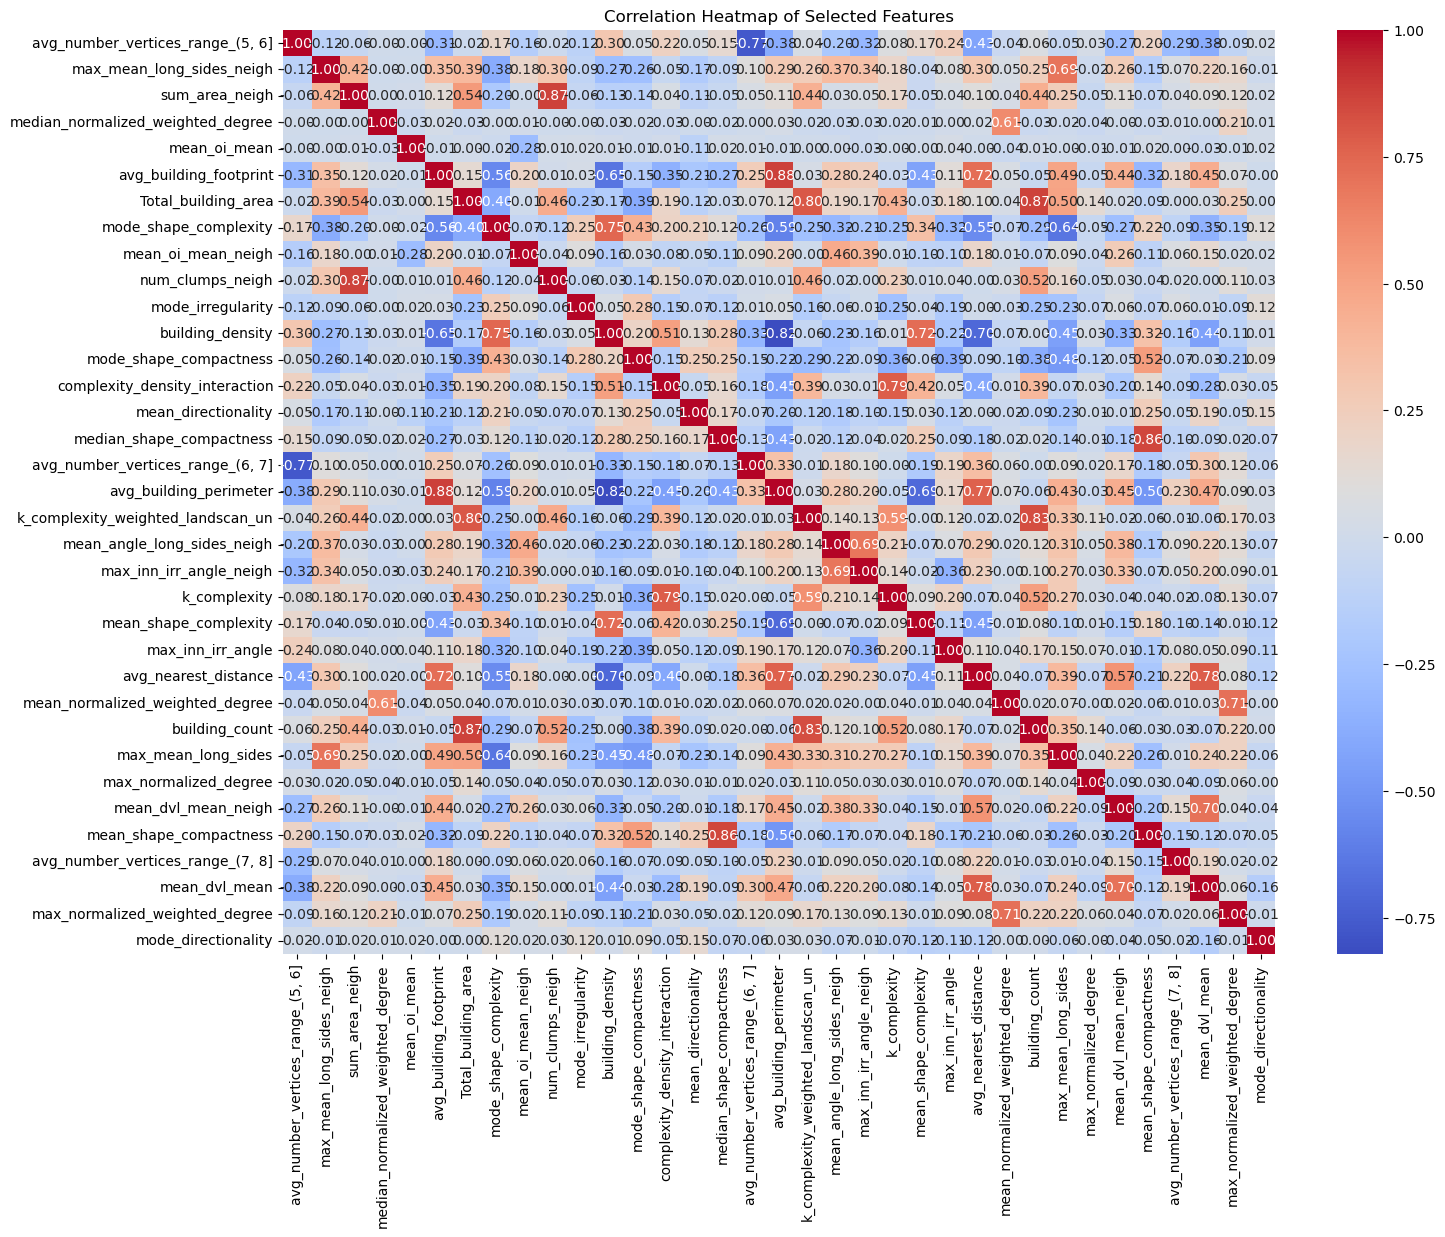

In [ ]:
# Selecting relevant columns for correlation heatmap
relevant_columns = final_selected_features
correlation_matrix = features[relevant_columns].corr()

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Selected Features')
plt.show()
fig.savefig('corr.jpeg', format='jpeg', dpi=300, bbox_inches='tight', facecolor='w')

## Data Analysis

###Model Development

In [ ]:
# Split the data into training and testing sets for Model 1 (DUAs)
X_train_slum, X_test_slum, y_train_slum, y_test_slum = train_test_split(features[final_selected_features], target_slum, test_size=0.2, random_state=42)

# Split the data into training and testing sets for Model 2 (Armed Conflict)
X_train_conflict, X_test_conflict, y_train_conflict, y_test_conflict = train_test_split(features[final_selected_features], target_conflict, test_size=0.2, random_state=42)

In [ ]:
# Use SMOTE-ENN to oversample the minority class
smote_slum = SMOTEENN(random_state=42)
X_train_slum_resampled, y_train_slum_resampled = smote_slum.fit_resample(X_train_slum, y_train_slum)


smote_conflict = SMOTEENN(random_state=42)
X_train_conflict_resampled, y_train_conflict_resampled = smote_conflict.fit_resample(X_train_conflict, y_train_conflict)

In [ ]:
#Target variable for Model 1(DUAs), distrbution after resampling
y_train_slum_resampled.value_counts()

y_Slum
1    4211
0    2254
Name: count, dtype: int64

In [ ]:
#Target variable for Model 2(Armed Conflict), distrbution after resampling
y_train_conflict_resampled.value_counts()

y_Conflict
1    6812
0    5328
Name: count, dtype: int64

In [ ]:
# Define parameter grid for Logistic reagression Grid Search
param_grid_rf = {
    'class_weight': ['balanced', None],
    'penalty' : [None, 'l2'],
    'solver' : [ 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag' ,'saga']
}
# Initialize the model
lr_model = LogisticRegression(max_iter=2000)

In [ ]:
# Perform Grid Search for Logistic Regression for Model 1(DUAs)
grid_search_slum = GridSearchCV(estimator=lr_model, param_grid=param_grid_rf,
                                   scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search_slum.fit(X_train_slum_resampled, y_train_slum_resampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'penalty': [None, 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring='f1', verbose=2)

In [ ]:
# Best parameters and best scores for Model 1(DUAs)
best_params_slum = grid_search_slum.best_params_
best_score_slum = grid_search_slum.best_score_

print("Best parameters for LR (y_Slum): ", best_params_slum)
print("Best score for LR (y_Slum): ", best_score_slum)


Best parameters for LR (y_Slum):  {'class_weight': None, 'penalty': None, 'solver': 'sag'}
Best score for LR (y_Slum):  0.9116082073699958


In [ ]:
# Perform Grid Search for Logistic regression for Model 2 (Armed Conflict)
grid_search_conflict = GridSearchCV(estimator=lr_model, param_grid=param_grid_rf,
                                   scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search_conflict.fit(X_train_conflict_resampled, y_train_conflict_resampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'penalty': [None, 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring='f1', verbose=2)

In [ ]:
# Best parameters and best scores for Model 2 (Armed Conflict)
best_params_conflict = grid_search_conflict.best_params_
best_score_conflict = grid_search_conflict.best_score_

print("Best parameters for LR (y_Conflict): ", best_params_conflict)
print("Best score for LR (y_Conflict): ", best_score_conflict)

Best parameters for LR (y_Conflict):  {'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Best score for LR (y_Conflict):  0.842610845748031


In [ ]:
#Train the logistic regression model for Model 1 (DUAs)
model_slum = LogisticRegression(random_state=42, max_iter=2000, solver='sag', penalty=None,class_weight=None)
model_slum.fit(X_train_slum_resampled, y_train_slum_resampled)

#Train the logistic regression model for Model 2 (Armed conflict)
model_conflict = LogisticRegression(random_state=42,max_iter=2000, solver='saga', penalty='l2',class_weight=None)
model_conflict.fit(X_train_conflict_resampled, y_train_conflict_resampled)

LogisticRegression(max_iter=2000, random_state=42, solver='saga')

In [ ]:
# Predict on the test set for Model 1 (DUAs)
y_pred_slum = model_slum.predict(X_test_slum)
y_prob_slum = model_slum.predict_proba(X_test_slum)[:, 1]

# Predict on the test set for Model 2 (Armed conflict)
y_pred_conflict = model_conflict.predict(X_test_conflict)
y_prob_conflict = model_conflict.predict_proba(X_test_conflict)[:, 1]


###Model Evaluation

In [ ]:
# Cross-validation for overfitting/underfitting check
cv_scores_slum = cross_val_score(model_slum, X_train_slum_resampled, y_train_slum_resampled, cv=5, scoring='f1')
cv_scores_conflict = cross_val_score(model_conflict, X_train_conflict_resampled, y_train_conflict_resampled, cv=5, scoring='f1')

print("Cross-validation scores for y_Slum: ", cv_scores_slum)
print("Mean cross-validation score for y_Slum: ", np.mean(cv_scores_slum))
print("Cross-validation scores for y_Conflict: ", cv_scores_conflict)
print("Mean cross-validation score for y_Conflict: ", np.mean(cv_scores_conflict))

Cross-validation scores for y_Slum:  [0.90581395 0.91120139 0.90898749 0.91810842 0.91392978]
Mean cross-validation score for y_Slum:  0.9116082073699958
Cross-validation scores for y_Conflict:  [0.84333821 0.84519442 0.84615385 0.84272129 0.83564646]
Mean cross-validation score for y_Conflict:  0.842610845748031


In [ ]:
# Evaluate final models on the test set for Model 1 (DUAs)
pred_slum_proba = model_slum.predict_proba(X_test_slum)[:, 1]

# Adjust decision thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
reports_slum = []

for threshold in thresholds:
    final_pred_slum = (pred_slum_proba >= threshold).astype(int)
    reports_slum.append(classification_report(y_test_slum, final_pred_slum, output_dict=True))


In [ ]:
# Evaluate final models on the test set for Model 2 (Armed conflict)
pred_conflict_proba = model_conflict.predict_proba(X_test_conflict)[:, 1]

# Adjust decision thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
reports_conflict = []

for threshold in thresholds:
    final_pred_conflict = (pred_conflict_proba >= threshold).astype(int)
    reports_conflict.append(classification_report(y_test_conflict, final_pred_conflict, output_dict=True))

In [ ]:
# Display reports for various decision thresholds
for i, threshold in enumerate(thresholds):
    print(f"Threshold: {threshold}")
    print("\nLogistic Regression- y_Slum")
    print(pd.DataFrame(reports_slum[i]).transpose())
    print("\nLogistic Regression - y_Conflict")
    print(pd.DataFrame(reports_conflict[i]).transpose())

Threshold: 0.1

Logistic Regression- y_Slum
              precision    recall  f1-score      support
0              0.956772  0.263492  0.413192  1260.000000
1              0.340909  0.969697  0.504467   495.000000
accuracy       0.462678  0.462678  0.462678     0.462678
macro avg      0.648841  0.616595  0.458829  1755.000000
weighted avg   0.783067  0.462678  0.438936  1755.000000

Logistic Regression - y_Conflict
              precision    recall  f1-score      support
0              0.991435  0.272353  0.427319  1700.000000
1              0.039596  0.927273  0.075949    55.000000
accuracy       0.292877  0.292877  0.292877     0.292877
macro avg      0.515515  0.599813  0.251634  1755.000000
weighted avg   0.961605  0.292877  0.416307  1755.000000
Threshold: 0.2

Logistic Regression- y_Slum
              precision    recall  f1-score      support
0              0.942857  0.340476  0.500292  1260.000000
1              0.360769  0.947475  0.522563   495.000000
accuracy       0.511681

In [ ]:
#Evaluate final models on the test set for Model 1 (DUAs) with the selected threshold of 0.75
final_pred_slum_proba = model_slum.predict_proba(X_test_slum)[:, 1]
final_pred_slum = (final_pred_slum_proba >= 0.75).astype(int)
final_report_slum = classification_report(y_test_slum, final_pred_slum)
final_roc_auc_slum = roc_auc_score(y_test_slum, final_pred_slum_proba)
final_f1_score_slum = f1_score(y_test_slum, final_pred_slum)

# Evaluate final models on the test set for Model 2 (Armed Conflict) with the selected threshold of 0.95
final_pred_conflict_proba = model_conflict.predict_proba(X_test_conflict)[:, 1]
final_pred_conflict = (final_pred_conflict_proba >= 0.95).astype(int)
final_report_conflict = classification_report(y_test_conflict, final_pred_conflict)
final_roc_auc_conflict = roc_auc_score(y_test_conflict, final_pred_conflict_proba)
final_f1_score_conflict = f1_score(y_test_conflict, final_pred_conflict)

print("Final Gradient Boosting Classification Report for y_Slum at threshold 0.75: ")
print(final_report_slum)
print("ROC AUC for y_Slum: ", final_roc_auc_slum)
print("F1 Score for y_Slum: ", final_f1_score_slum)

print("Final Gradient Boosting Classification Report for y_Conflict at threshold 0.95: ")
print(final_report_conflict)
print("ROC AUC for y_Conflict: ", final_roc_auc_conflict)
print("F1 Score for y_Conflict: ", final_f1_score_conflict)

Final Gradient Boosting Classification Report for y_Slum at threshold 0.75: 
              precision    recall  f1-score   support

           0       0.87      0.67      0.76      1260
           1       0.47      0.75      0.58       495

    accuracy                           0.69      1755
   macro avg       0.67      0.71      0.67      1755
weighted avg       0.76      0.69      0.71      1755

ROC AUC for y_Slum:  0.7703463203463203
F1 Score for y_Slum:  0.5792778649921507
Final Gradient Boosting Classification Report for y_Conflict at threshold 0.95: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1700
           1       0.30      0.24      0.26        55

    accuracy                           0.96      1755
   macro avg       0.64      0.61      0.62      1755
weighted avg       0.95      0.96      0.96      1755

ROC AUC for y_Conflict:  0.781283422459893
F1 Score for y_Conflict:  0.26262626262626265


###Model Interpretation

In [ ]:
# Extract feature importances (coefficients) from the models
importance_depravity = model_slum.coef_[0]
importance_conflict = model_conflict.coef_[0]

# Create a DataFrame for comparison
df_multi_actual = pd.DataFrame({
    'Feature': features[final_selected_features].columns,
    'Importance_Depravity_Multi': importance_depravity,
    'Importance_Conflict_Multi': importance_conflict
})

{'Pearson Correlation Multi-task (Actual Data)': 0.5045461453944476,
 'Pearson P-Value Multi-task (Actual Data)': 0.0019963515164389974,
 'Spearman Correlation Multi-task (Actual Data)': 0.23361344537815126,
 'Spearman P-Value Multi-task (Actual Data)': 0.17680483603344388}

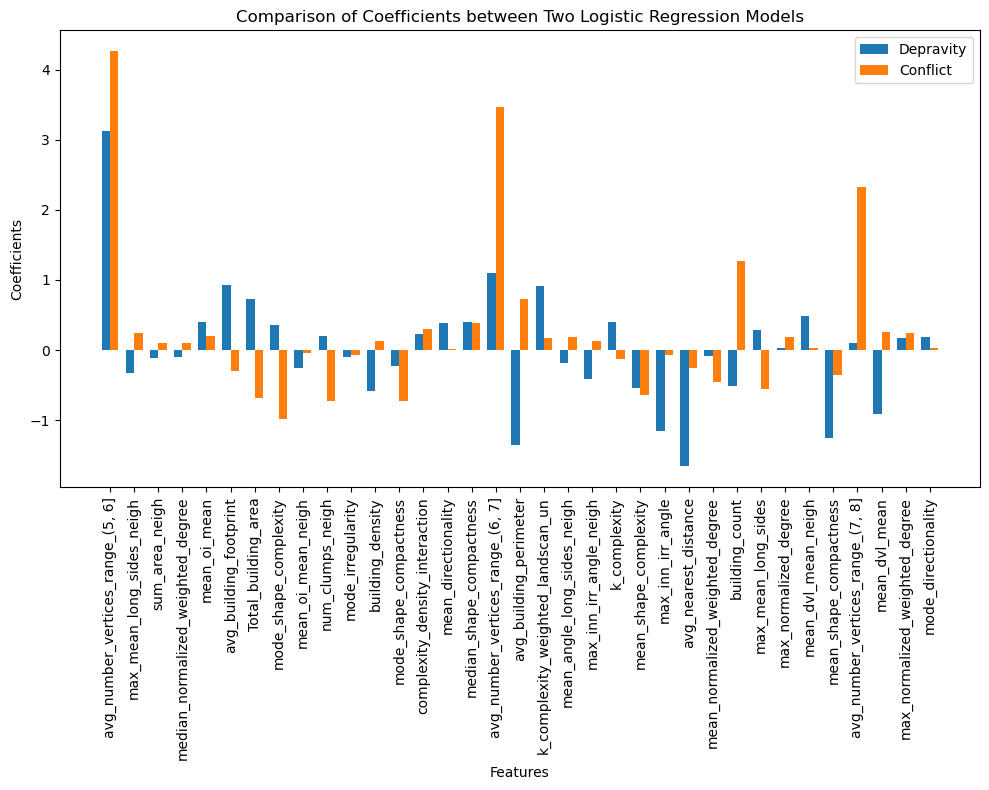

In [ ]:
# Visualize the comparison

fig, ax = plt.subplots(figsize=(10, 8))

index = np.arange(len(df_multi_actual))
bar_width = 0.35

bar1 = ax.bar(index, df_multi_actual['Importance_Depravity_Multi'], bar_width, label='Depravity')
bar2 = ax.bar(index + bar_width, df_multi_actual['Importance_Conflict_Multi'], bar_width, label='Conflict')

ax.set_xlabel('Features')
ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Coefficients between Two Logistic Regression Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_multi_actual['Feature'], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig('Beta Coefficients.jpeg', format='jpeg', dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
# Estimate standard errors using the inverse of the Hessian matrix
se_model1 = np.sqrt(np.diag(np.linalg.inv(np.dot(X_train_slum_resampled.T, X_train_slum_resampled))))
se_model2 = np.sqrt(np.diag(np.linalg.inv(np.dot(X_train_conflict_resampled.T, X_train_conflict_resampled))))

# Compute the z-scores
z_scores = (importance_depravity - importance_conflict) / np.sqrt(se_model1**2 + se_model2**2)

# Compute the p-values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Create a dataframe for comparison
coefficients_df = pd.DataFrame({
    'Feature': features[final_selected_features].columns,
    'depravity': importance_depravity,
    'conflict': importance_conflict,
    'Z-Score': z_scores,
    'P-Value': p_values
})

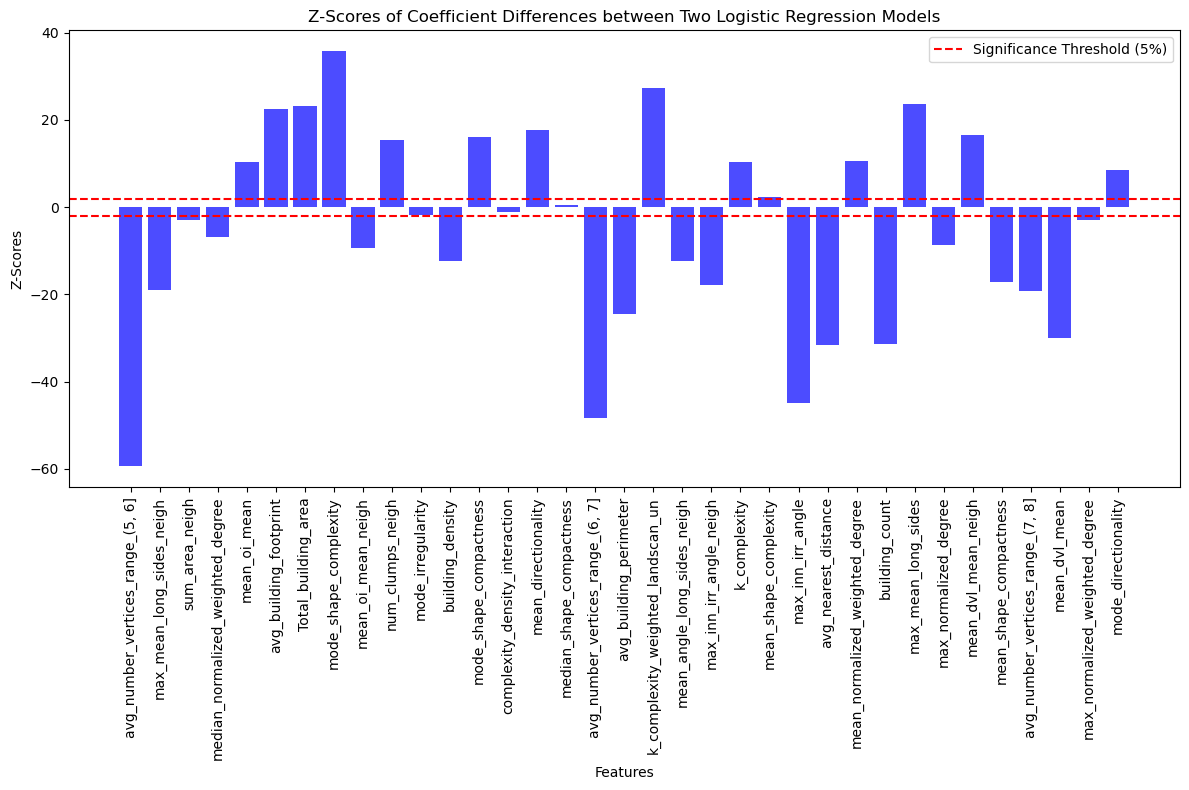

In [ ]:
# Create a bar plot for Z-scores
fig, ax = plt.subplots(figsize=(12, 8))

plt.bar(coefficients_df['Feature'], coefficients_df['Z-Score'], color='b', alpha=0.7)
plt.axhline(y=1.96, color='r', linestyle='--', label='Significance Threshold (5%)')
plt.axhline(y=-1.96, color='r', linestyle='--')

plt.xlabel('Features')
plt.ylabel('Z-Scores')
plt.title('Z-Scores of Coefficient Differences between Two Logistic Regression Models')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig('Zscore.jpeg', format='jpeg', dpi=300, bbox_inches='tight', facecolor='w')
